# Day 2 ATIS-2025 Workshop

## Part A — Quantum Teleportation


### Import Libraries

In [ ]:
!pip install qiskit
!pip install qiskit qiskit_machine_learning qiskit_algorithms
!pip install qiskit-aer

{'01': 262, '11': 251, '10': 227, '00': 284}


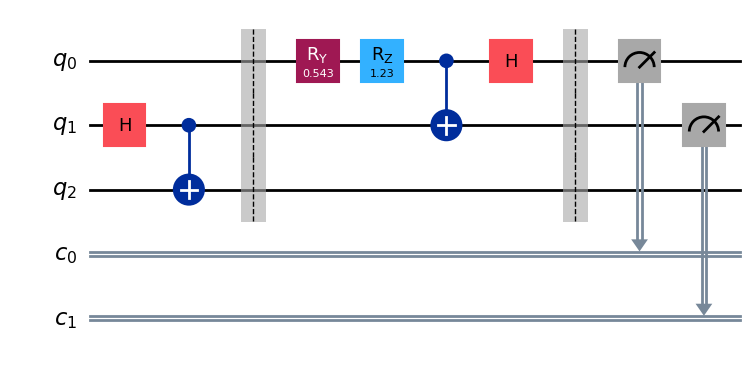

In [15]:
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator

# name the qubits q0: message, q1: alice, q2: bob
qc = QuantumCircuit(3, 2)
qc.h(1)
qc.cx(1,2)
qc.barrier()
qc.ry(0.543,0)
qc.rz(1.234,0)
qc.cx(0,1)
qc.h(0)
qc.barrier()
qc.measure([0,1],[0,1])
simulator = AerSimulator()
compiled_circuit = transpile(qc, simulator)
result = simulator.run(compiled_circuit, shots=1024).result()
counts = result.get_counts(compiled_circuit)
print(counts)
qc.draw('mpl', cregbundle=False)